In [1]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import time
from itertools import chain
import math
from operator import itemgetter
from collections import Counter

In [2]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","85g")
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__)
spark.version

/home/antslab/anaconda3/bin/python
3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
0.33.0


'3.0.0-preview2'

In [3]:
in_file = "/home/antslab/123data_hdd4t/pcap_process/pcap_spark/2020_01_11/中華電信/parquet/2020_01_11_session_v7-2_hashpayload_time_size.parquet"
pickle_dir = '/home/antslab/123_pcap_inter/2020_01_11/中華電信/case_pickles/'
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir,exist_ok=True)
df = ks.read_parquet(in_file) #pd/ks
print(df.columns)
df = df[['session_time','session_time_list','session_duration','session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
             'session_tt_frame_length', 'session_i_tt_frame_length','session_o_tt_frame_length','udp_tt_length', 'udp_i_tt_length',
             'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
             'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
             'icmp_o_avg_datagram_length','tcp_tt_payload_length', 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
             'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
             'city', 'subdivisions','domain','isp','frame_i_common_protocols','frame_o_common_protocols', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
            ]]
# df['tcp_payload_avg'] = df.tcp_payload_size/df.session_packets
# df['udp_payload_size'] = df.udp_length_sum - (df.session_packets*8)
# df['udp_payload_avg'] = df.udp_payload_size/df.session_packets
# df['icmp_payload_avg'] = df.icmp_length_original_datagram_sum/df.session_packets

 #50461592 
gc.collect()
# df

Index(['session_time', 'session_time_list', 'session_duration',
       'session_tt_packet', 'session_i_tt_packet', 'session_o_tt_packet',
       'session_tt_frame_length', 'session_i_tt_frame_length',
       'session_o_tt_frame_length', 'udp_tt_length', 'udp_i_tt_length',
       'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length',
       'icmp_tt_length', 'icmp_i_tt_length', 'icmp_o_tt_length',
       'icmp_i_avg_length', 'icmp_o_avg_length',
       'icmp_tt_original_datagram_length', 'icmp_i_tt_datagram_length',
       'icmp_o_tt_datagram_length', 'icmp_i_avg_datagram_length',
       'icmp_o_avg_datagram_length', 'tcp_hdr_len_sum',
       'tcp_tt_payload_length', 'tcp_i_tt_payload_length',
       'tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
       'tcp_o_avg_payload_length', 'ip_avg_ttl', 'ip_max_ttl',
       'tcp_avg_window', 'tcp_max_window', 'ip_src', 'ip_dst', 'ip_proto',
       'tcp_srcport', 'tcp_dstport', 'udp_srcport', 'udp_dstport', 'country',
       'city', '

516

In [4]:
 #篩選出有in bound payload的session
df1 = df[(df.session_duration>0.1)&(df.session_i_tt_packet>1)&(df.session_i_tt_frame_length>0)&
         (df.tcp_i_payload_list.astype(str)!='[]')]
df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
        (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]
gc.collect()
# df1

513

In [5]:
df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')&(df1.session_o_tt_packet>0)&(df1.session_o_tt_frame_length>0)]
df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
        (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')]
gc.collect()
# df2
df2 = df2.to_pandas()

In [15]:
print(df2.domain.value_counts().head(60))
df2.isp.value_counts().head(60)

hinet.net                        403936
netvigator.com                    99571
dvois.com                         76370
elcat.kg                          55807
brasiltelecom.net.br              48058
mediana.net.ua                    44645
vnpt.vn                           39949
wildpark.net                      29916
corbina.ru                        29826
cableonline.com.mx                28966
viettel.vn                        23523
cantv.net                         22869
actcorp.in                        22575
veetime.com                       21961
btc-net.bg                        19089
pldt.net                          13751
163data.com.cn                    13083
tedata.net                        12506
ip-193-70-6.eu                    11604
ip-94-23-145.eu                   10751
telkom.net.id                      9151
linode.com                         8430
multi.net.pk                       7031
nexlinx.net.pk                     6357
totinternet.net                    5994


HiNet                                              959776
BSNL                                               153204
Hangzhou Alibaba Advertising Co.,Ltd.              132246
Netvigator                                          99940
China Mobile Guangdong                              85837
OVH SAS                                             77293
D-Vois Broadband Pvt                                76373
Telecom Argentina S.A.                              67821
Viettel Group                                       58535
ElCat Ltd.                                          55807
VNPT                                                49906
Oi Internet                                         49359
Mediana ltd.                                        44645
Tencent cloud computing                             44397
China Telecom                                       40160
FPT Telecom Company                                 39188
PT Telkom Indonesia                                 32928
WildPark Co   

## Functionizze

In [ ]:
 
def prepare_df(df2,protocol_name,split="size"):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            return sorted(data,key=itemgetter(2))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time,size)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time,size)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload

    df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.map(sort_fn)
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    return df2_protocol, df2_protocol_payload

In [ ]:
def similarity_compare(df2_protocol,df2_protocol_payload,thr=0,thr2=10): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Pick max value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in tqdm(df2_protocol.index):
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
        candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidate
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            big_dict_protocol[idx] = idx_li
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores#,big_dict_protocol2 #test

In [ ]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key)
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
    print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#'+str(case_id)+'_threetuples.pkl','wb'))

In [ ]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [ ]:
def cluster_stat(protocol_big_dict,protocol_df):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前三大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
#     series = pandas.Series(np.random.normal(size=2000))
    fig, ax = plt.subplots()
    protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
    ax.set_yscale('log')

http

In [57]:
http_df, http_df_payload = prepare_df(df2,'http')
http_big_dict,http_loner = similarity_compare(http_df,http_df_payload)
gc.collect() #05:38

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

5305

原本總共sessions#: 97875
共有#sessions可分群: 98053 共有#lonerSessions: -178
可分為#群: 178
前五大的cluster key與對應之群集大小
 394    27249
423    15168
554    12970
454    11360
347     4409
Name: 0, dtype: int64
                  0
count    178.000000
mean     550.859551
std     2699.125449
min        2.000000
25%        3.000000
50%        6.000000
75%       29.750000
max    27249.000000


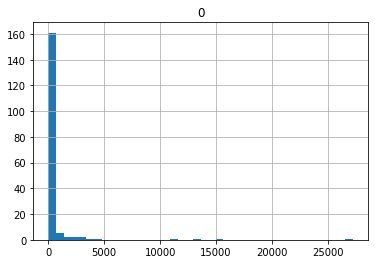

In [59]:
def cluster_stat(protocol_big_dict,protocol_df):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前五大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    protocol_stat_df.hist(bins=40)
    
cluster_stat(http_big_dict,http_df) #可分為#群: 159 共有#sessions可分群: 143363 共有#lonerSessions: 49

In [14]:
# pickle_dir = '/home/antslab/123_antslab/spark_data/pcap_inter/2020_01_09/中華電信/case_pickles/'
write2pkl(http_df,http_big_dict,394,"http_1")
write2pkl(http_df,http_big_dict,423,"http_2")
write2pkl(http_df,http_big_dict,554,"http_3")
write2pkl(http_df,http_big_dict,454,"http_4")
write2pkl(http_df,http_big_dict,347,"http_5")

Unique Country#: 137 Unique IP#: 7989 Session#: 27248
Unique Country#: 29 Unique IP#: 145 Session#: 15167
Unique Country#: 31 Unique IP#: 575 Session#: 12969
Unique Country#: 96 Unique IP#: 1524 Session#: 11359
Unique Country#: 36 Unique IP#: 213 Session#: 4408


In [61]:
min(all_nums),max(all_nums),np.mean(all_nums),np.std(all_nums),np.median(all_nums)

(1, 76986, 1344.4293785310736, 7011.119688363667, 13.0)

In [60]:
554 in http_big_dict[554]

True

In [24]:
sum(all_nums)

419623

In [117]:
# def split_col_len(session):
#     '''
#     input: list(session) of lists(packets) =>tuple=(hash,time)
    
#     Return1: list of ssdeep length
#     Return2: list of session's packets hashes
#     '''
# #     for session in payload_li:
#     packet_payload = []
#     packet_len = []
#     for packet in session:
#         ssdeep_hash = packet[0]
# #         packet_payload.append(ssdeep_hash)
#         packet_len.append(ssdeep_hash.split(':')[0])
#     return packet_len#,packet_payload

# def split_col_hash(session):
#     '''
#     input: list(session) of lists(packets) =>tuple=(hash,time)
    
#     Return1: list of ssdeep length
#     Return2: list of session's packets hashes
#     '''
# #     for session in payload_li:
#     packet_payload = []
#     packet_len = []
#     for packet in session:
#         ssdeep_hash = packet[0]
#         packet_payload.append(ssdeep_hash)
# #         packet_len.append(ssdeep_hash.split(':')[0])
#     return packet_payload

In [190]:
# df2_http_payload = df2_http[['tcp_i_payload_list']]
# df2_http_payload['size'] = df2_http_payload.tcp_i_payload_list.map(split_col_len) #,df2_http_payload['hash']
# df2_http_payload['hash'] = df2_http_payload.tcp_i_payload_list.map(split_col_hash)
# L_size = [x if isinstance(x, list) else [x] for x in df2_http_payload['size']]
# L_hash = [x if isinstance(x, list) else [x] for x in df2_http_payload['hash']]
# df2_http_payload = pd.DataFrame({
#     'idx':df2_http_payload.index.values.repeat([len(x) for x in L_size]),
#     'size':list(chain.from_iterable(L_size)),
#     'hash':list(chain.from_iterable(L_hash))
#     })
# # df2_http_payload['idx'] = 
# df2_http_payload['size'] = df2_http_payload['size'].astype(int)
# df2_http_payload

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,idx,size,hash
0,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
1,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
2,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
3,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
4,92,6,6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHX...
...,...,...,...
336089,50455495,12,12:rHXqzNkZfcqL6xmMReH1JNkH18YH14NIL18YH1IyESu...
336090,50461064,12,12:DC779Xdykq16Bn6R7o6sD/XmHXqrI2ErB5cuXNQNcxY...
336091,50461202,3,3:cRm5tD+U/2:rHKA2
336092,50461202,3,3:Sfrfun:Sfrmn


In [270]:
# def ssdeep_compare(target_hash,candidate_df):
#     '''
#     Input1: string of hash
#     Input2: dataframe of candidate
#     '''
#     def compare(candidate_hash):
#         return ssdeep.compare(target_hash,candidate_hash)
#     return candidate_df.hash.map(compare)
# big_dict_http = {}
# used_idx_li = []
# for idx in tqdm(df2_http.index):
#     if idx in used_idx_li:
#         continue
#     target = df2_http_payload[df2_http_payload.idx == idx]
#     target = target.reset_index(drop=True)
#     t_len = len(target)
#     q1 = int(t_len*0.25)
#     q2 = int(t_len*0.5)
#     q3 = int(t_len*0.75)
#     t_q1 = target.iloc[q1,-1]
#     t_q2 = target.iloc[q2,-1]
#     t_q3 = target.iloc[q3,-1]
#     candidate = df2_http_payload[df2_http_payload.idx>idx]
#     candidate['idx'] = candidate.idx.astype(str)
#     candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]]
#     candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
#     candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]]
#     candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
#     candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]]
#     candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
#     candidate = candidate.drop(['size','hash'],axis=1)
#     candidate['score'] = candidate.max(axis=1)
#     candidate = candidate[candidate.score>=40] #相似度分數，數字越小速度愈快、數字越大越多群
#     candidate['idx'] = candidate.idx.astype(int)
#     idx_li = candidate.idx.tolist()
#     if len(idx_li)>0:
#         big_dict_http[idx] = idx_li
#         used_idx_li.extend(idx_li)
#         used_idx_li = list(set(used_idx_li))
# #     candidate_q2 = 
    
    
# #     break
# #     candidate = 

  0%|          | 0/238178 [00:00<?, ?it/s]/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


畫distribution
* 針對某單一case進行

In [12]:
def case_study(idx,payload_df):
    '''
    idx: which index is the dataframe's target?
    payload_df: protocol payload dataframe (packet-based)
    下面有一些參數可以改 (line19~23、27註解處)
    
    Return: Big dict
    '''
    big_dict = {}
    idx = int(idx)
    target = payload_df[payload_df.idx == idx]
    target = target.reset_index(drop=True)
    t_len = len(target)
    t_q1 = target.iloc[int(t_len*0.25),-1]
    t_q2 = target.iloc[int(t_len*0.5),-1]
    t_q3 = target.iloc[int(t_len*0.75),-1]
    candidate = payload_df[payload_df.idx != idx]
    candidate['idx'] = candidate.idx.astype(str)
    candidate_q1 = candidate[candidate['size']==target.iloc[int(t_len*0.25),-2]] #是否要match: match改成== 不match改成!=
    candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
    candidate_q2 = candidate[candidate['size']==target.iloc[int(t_len*0.5),-2]] # == or != (score=0)
    candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
    candidate_q3 = candidate[candidate['size']==target.iloc[int(t_len*0.75),-2]] #要找不像的時候要改成!=
    candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
    candidate = candidate.drop(['size','hash'],axis=1)
    candidate['score'] = candidate.max(axis=1)
    candidate = candidate[candidate.score>0] #相似度分數，數字越小速度愈快、數字越大越多群。要抓出幾分的人> == <
    candidate['idx'] = candidate.idx.astype(int)
    idx_li = candidate.idx.tolist()
    if len(idx_li)>0:
        big_dict[idx] = idx_li
    # len(big_dict.keys())
    print("所有該protocol與所給定之target的分數種類:",candidate.score.unique())
    print("總session數量:",len(big_dict[idx]))
    print("分數的分布:",candidate.score.value_counts().sort_index())
    print("分數的分布圖:",candidate.score.hist(bins=25))
    return big_dict, candidate

In [328]:
candidate.score.value_counts().sort_index()#.sum()

40.0     1
41.0     2
43.0    14
44.0    14
46.0     2
47.0    87
49.0    14
50.0    52
52.0     1
54.0    51
55.0     7
57.0    67
58.0    12
60.0    79
61.0    22
63.0    72
65.0    41
66.0    67
68.0    52
69.0    38
71.0    47
72.0    25
74.0    27
75.0    10
77.0    10
79.0     9
80.0    15
82.0     8
83.0    16
85.0     4
86.0    11
88.0     9
90.0     3
91.0     4
94.0     2
Name: score, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


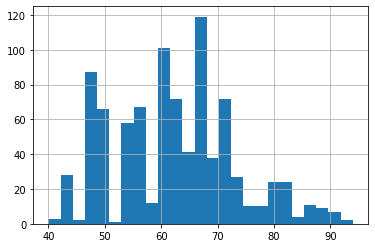

In [345]:
print(candidate.score.hist(bins=25))

In [315]:
candidate.score.describe()

count    895.000000
mean      62.375419
std       10.893108
min       40.000000
25%       54.000000
50%       63.000000
75%       69.000000
max       94.000000
Name: score, dtype: float64

In [13]:
def save_wireshark(df2_protocol,pkl_name,only_one=False):
    '''
    GOAL: save frame time list to pkl for Jerry to output wireshark pcap
    df2_protocol: protocol original dataframe (session-based)
    '''
    protocol_thr = df2_protocol.loc[big_dict_sqlmap[idx]]
    # protocol_thr = df2_protocol.loc[80891]  #也可只輸出一個特定sessiono的time frame list就好
    protocol_thr = protocol_thr.session_time_list.tolist()
    if not only_one:
        protocol_thr = [list(x) for x in protocol_thr]
    pickle.dump(obj=protocol_thr,file=open(pickle_dir+str(pkl_name)+'.pkl','wb'))
    print("總共具有的sessions數量:",len(protocol_thr))
# protocol_thr

sql map http

In [277]:
df2_http[df2_http.ip_src == '190.92.5.158'].index

Int64Index([   80890,    80891,    80892,   334327,   334328,   334329,
              334330,   334331,   334332,   334335,
            ...
            49785502, 50037370, 50037371, 50037372, 50290869, 50290870,
            50290871, 50290872, 50290873, 50290874],
           dtype='int64', length=819)

In [278]:
for k,v in big_dict_http.items():
    if 80891 in v:
        print(k)
        break

2394


In [279]:
case1_diagram = df2_http.loc[list(set(big_dict_http[2394]))]
time_lists = case1_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case1_diagram.ip_src.tolist()
countries = case1_diagram.country.tolist()
print(len(countries),len(ips))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#1_threetuples.pkl','wb'))

905 905


In [280]:
case1_diagram.ip_src.unique()

array(['103.16.71.248', '117.1.16.131', '190.92.5.158', '109.198.110.234'],
      dtype=object)

#### SAMBA payload

In [15]:
smb_df, smb_df_payload = prepare_df(df2,'smb')
smb_big_dict = similarity_compare(smb_df,smb_df_payload)
gc.collect()

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

5106

原本總共sessions#: 276092
共有#sessions可分群: 276091 共有#lonerSessions: 1
可分為#群: 2
前五大的cluster key與對應之群集大小
 0       275581
9911       510
Name: 0, dtype: int64
                   0
count       2.000000
mean   138045.500000
std    194504.569408
min       510.000000
25%     69277.750000
50%    138045.500000
75%    206813.250000
max    275581.000000


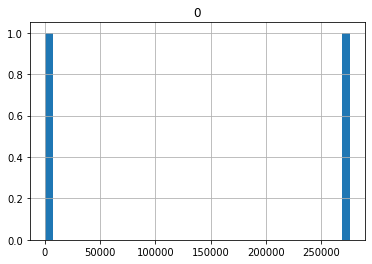

In [16]:
cluster_stat(smb_big_dict,smb_df)

In [17]:
write2pkl(smb_df,smb_big_dict,0,"smb_1")
write2pkl(smb_df,smb_big_dict,9911,"smb_2")
# write2pkl(smb_df,smb_big_dict,,"smb_3")


Unique Country#: 128 Unique IP#: 5541 Session#: 275581
Unique Country#: 24 Unique IP#: 66 Session#: 510


In [281]:
# def split_col_len(session):
#     '''
#     input: list(session) of lists(packets) =>tuple=(hash,time)
    
#     Return1: list of ssdeep length
#     Return2: list of session's packets hashes
#     '''
# #     for session in payload_li:
#     packet_payload = []
#     packet_len = []
#     for packet in session:
#         ssdeep_hash = packet[0]
# #         packet_payload.append(ssdeep_hash)
#         packet_len.append(ssdeep_hash.split(':')[0])
#     return packet_len#,packet_payload

# def split_col_hash(session):
#     '''
#     input: list(session) of lists(packets) =>tuple=(hash,time)
    
#     Return1: list of ssdeep length
#     Return2: list of session's packets hashes
#     '''
# #     for session in payload_li:
#     packet_payload = []
#     packet_len = []
#     for packet in session:
#         ssdeep_hash = packet[0]
#         packet_payload.append(ssdeep_hash)
# #         packet_len.append(ssdeep_hash.split(':')[0])
#     return packet_payload

In [282]:
# df2_smb = df2[(df2.frame_i_max_protocols.str.contains('smb'))&(df2.frame_o_max_protocols.str.contains('smb'))]
# df2_smb_payload = df2_smb[['tcp_i_payload_list']]
# df2_smb_payload['size'] = df2_smb_payload.tcp_i_payload_list.map(split_col_len) #,df2_smb_payload['hash']
# df2_smb_payload['hash'] = df2_smb_payload.tcp_i_payload_list.map(split_col_hash)
# L_size = [x if isinstance(x, list) else [x] for x in df2_smb_payload['size']]
# L_hash = [x if isinstance(x, list) else [x] for x in df2_smb_payload['hash']]
# df2_smb_payload = pd.DataFrame({
#     'idx':df2_smb_payload.index.values.repeat([len(x) for x in L_size]),
#     'size':list(chain.from_iterable(L_size)),
#     'hash':list(chain.from_iterable(L_hash))
#     })
# # df2_smb_payload['idx'] = 
# df2_smb_payload['size'] = df2_smb_payload['size'].astype(int)
# df2_smb_payload

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,idx,size,hash
0,10,6,6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVIi...
1,10,6,6:9dsdwLW0Vf6IMXvS66cXvTrV1P/Y0Vf6IMXvS66cK/iC...
2,10,6,6:g+p51VudwOwMrV10KDBQf//sSAvSAUqYyEfEfEfVV:g+...
3,10,3,3:11R6T5gvXV1V1Udwa3vV1V1V1V1V1V1V1V1V1V133ffc...
4,11,6,6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVIi...
...,...,...,...
1452833,50461550,3,3:11R2f486fV1V1V1Ud2FV1V1V1V1V1V1V1V1V1V133fff...
1452834,50461562,6,6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcVIi...
1452835,50461562,6,6:9dsdwLW0Vf6IMXvS66cXvTrV1P/Y0Vf6IMXvS66cK/iC...
1452836,50461562,6,6:g+p51VudwOwMrV10KDBQf//sSAvSAUqYyEfEfEfVV:g+...


In [283]:
# def ssdeep_compare(target_hash,candidate_df):
#     '''
#     Input1: string of hash
#     Input2: dataframe of candidate
#     '''
#     def compare(candidate_hash):
#         return ssdeep.compare(target_hash,candidate_hash)
#     return candidate_df.hash.map(compare)
# big_dict_smb = {}
# used_idx_li = []
# for idx in tqdm(df2_smb.index):
#     if idx in used_idx_li:
#         continue
#     target = df2_smb_payload[df2_smb_payload.idx == idx]
#     target = target.reset_index(drop=True)
#     t_len = len(target)
#     q1 = int(t_len*0.25)
#     q2 = int(t_len*0.5)
#     t_q1 = target.iloc[q1,-1]
#     candidate = df2_smb_payload[df2_smb_payload.idx>idx]
#     candidate['idx'] = candidate.idx.astype(str)
#     candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]]
#     candidate['q1'] = ssdeep_compare(t_q1,candidate_q1)
#     if q2 != q1:
#         t_q2 = target.iloc[q2,-1]
#         q3 = int(t_len*0.75)
#         candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]]
#         candidate['q2'] = ssdeep_compare(t_q2,candidate_q2)
#         if q3 != q2:
#             t_q3 = target.iloc[q3,-1]
#             candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]]
#             candidate['q3'] = ssdeep_compare(t_q3,candidate_q3)
#     candidate = candidate.drop(['size','hash'],axis=1)
#     candidate['score'] = candidate.max(axis=1)
#     candidate = candidate[candidate.score>=40] #相似度分數，數字越小速度愈快、數字越大越多群
#     candidate['idx'] = candidate.idx.astype(int)
#     idx_li = candidate.idx.tolist()
#     if len(idx_li)>0:
#         big_dict_smb[idx] = idx_li
#         used_idx_li.extend(idx_li)
#         used_idx_li = list(set(used_idx_li))

  0%|          | 0/352131 [00:00<?, ?it/s]/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [287]:
df2_smb[df2_smb.ip_src == '113.189.231.122']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
512421,1.578621e+09,"[1578620529.412071, 1578620529.412273, 1578620...",120.234741,16,8,8,1508,808.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,29.000000,113.189.231.122,210.242.148.79,63087.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
3032491,1.578622e+09,"[1578621628.633667, 1578621628.633879, 1578621...",0.792706,19,8,11,1905,899.0,1006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819.0,455.0,364.0,56.875000,33.090909,113.189.231.122,210.242.148.116,61267.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oEyoa0VfCy/a9evgfey9FV1RG/5r...
4040632,1.578621e+09,"[1578621227.633486, 1578621227.633716, 1578621...",0.497820,17,8,9,1785,899.0,886.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819.0,455.0,364.0,56.875000,40.444444,113.189.231.122,210.242.148.107,53067.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[6:iCV00dYMe9hNV9oEyoa0VfCy/a9evgfey9FV1RG/5r...
6309898,1.578622e+09,"[1578622269.756694, 1578622269.75692, 15786222...",120.353363,18,8,10,1628,808.0,820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,23.200000,113.189.231.122,210.242.148.127,60517.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
6309899,1.578618e+09,"[1578618069.221727, 1578618072.309224, 1578618...",26.334930,23,11,12,2303,1222.0,1081.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.0,592.0,373.0,53.818182,31.083333,113.189.231.122,210.242.148.3,57019.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[6:wV08dY0TAqRARUbESX1qvasTgb+RpoedfFKXqEPdcV...,[[3:11QQoW503vV1V1cdxYvV1V1V1V1V1V1V1V1V1V1V1V...
6561208,1.578620e+09,"[1578620021.157126, 1578620021.157317, 1578620...",120.510231,18,8,10,1628,808.0,820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,45.500000,23.200000,113.189.231.122,210.242.148.71,59052.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:nbss:smb,eth:ethertype:ip:tcp:nbss:smb,[[3:11QRfDp03vV1V1Ud2FV1V1V1V1V1V1V1V1V1V1V1V1...,[[3:11QQoW503vV1V1cdcV1V1V1V1V1V1V1V1V1V133FfX...
7823475,1.578621e+09,"[1578621362.046162, 1578621362.046305, 1578621...",0.700609,14,6,8,1400,700.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,364.0,232.0,60.666667,29.000000,113.189.231.122,210.242.148.112,50151.0,445.0,NaN,NaN,Vietnam,Bac Ninh,Tinh Bac Ninh,vnpt.v

In [288]:
big_dict_smb[512421] #KeyError

for k,v in big_dict_smb.items():
    if 512421 in v:
        print(k)
        break

KeyError: 512421

In [293]:
case2_diagram = df2_smb.loc[list(set(big_dict_smb[10]))]
time_lists = case2_diagram.session_time_list.tolist()
time_lists = [list(x) for x in time_lists]
ips = case2_diagram.ip_src.tolist()
countries = case2_diagram.country.tolist()
print(len(set(countries)),len(set(ips)))
# pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#2_threetuples.pkl','wb'))

141 9056


#### Functionize

In [38]:
 
def prepare_df(df2,protocol_name):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        return sorted(data,key=itemgetter(2))
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload

    df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.map(sort_fn)
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    return df2_protocol, df2_protocol_payload

In [111]:
def similarity_compare(df2_protocol,df2_protocol_payload,thr=0,thr2=10): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Pick max value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in tqdm(df2_protocol.index):
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
        candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidate
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            big_dict_protocol[idx] = idx_li
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores#,big_dict_protocol2 #test

* 改成pool

In [9]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [11]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key)
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
    print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(pickle_dir+'case#'+str(case_id)+'_threetuples.pkl','wb'))

In [103]:
telnet_df, telnet_df_payload = prepare_df(df2,'telnet')
telnet_big_dict,telnet_loners = similarity_compare(telnet_df,telnet_df_payload)
gc.collect()

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

8

In [110]:
telnet_df[['session_tt_packet','session_i_tt_packet','session_o_tt_packet']]#.mean(axis=1)

,session_tt_packet,session_i_tt_packet,session_o_tt_packet
17179872621,14,9,5
17179883041,11,7,4
34359741762,11,7,4
34359741774,14,9,5
51539627739,101,55,46
...,...,...,...
824633724218,11,7,4
833223668791,17,11,6
841813604032,8,5,3
850403528373,9,5,4


In [106]:
df2.loc[telnet_loners]

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,isp,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
283467858287,1.578734e+09,"[1578733548.995317, 1578733548.995604, 1578733...",47.760765,10,6,4,661,394,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,50,27,8.333333,6.75,211.95.50.4,210.242.148.25,10740,23,NaN,NaN,China,None,None,None,China Unicom Shanghai,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,"[[3:s671FIL7Q/V1V//vV1VYB:s6fIL7QI, 1578733549...","[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157873..."
395137005290,1.578748e+09,"[1578748210.628486, 1578748211.632201, 1578748...",14.222727,18,12,6,1275,828,447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,32,27,2.666667,4.50,204.93.154.208,210.242.145.57,58838,23,NaN,NaN,United States,None,None,scnet.net,None,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,"[[3:ro53fg5T:ro2N, 1578748211.828533000, 8], [...","[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157874..."
790273999135,1.578733e+09,"[1578733297.729276, 1578733297.729448, 1578733...",45.313347,9,5,4,590,323,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,33,27,6.600000,6.75,211.95.50.5,210.242.148.23,3410,23,NaN,NaN,China,None,None,None,China Unicom Shanghai,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[3:3D/UdfrzC5SW/J2DrV7/UCVfFfrfVJDd/:gdCf+raC...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157873..."


In [104]:
17179872621 in telnet_big_dict[17179872621]

False

In [97]:
for k,v in telnet_big_dict.items():
    if len(v) == 1:
        print(k,v)

231928237723 [807453852172]


原本總共sessions#: 107
共有#sessions可分群: 104 共有#lonerSessions: 3
可分為#群: 7
前五大的cluster key與對應之群集大小
 17179872621     61
77309424506     13
85899356725     12
51539627739      6
309237656125     5
Name: 0, dtype: int64
               0
count   7.000000
mean   14.857143
std    20.731848
min     2.000000
25%     5.000000
50%     6.000000
75%    12.500000
max    61.000000


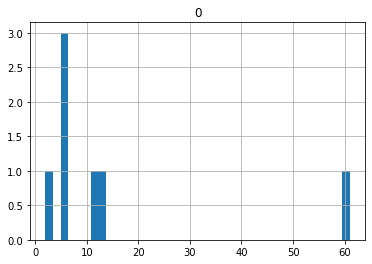

In [105]:
cluster_stat(telnet_big_dict,telnet_df)

In [20]:
write2pkl(telnet_df,telnet_big_dict,17179872621,"telnet_1")
write2pkl(telnet_df,telnet_big_dict,77309424506,"telnet_2")
write2pkl(telnet_df,telnet_big_dict,85899356725,"telnet_3")


Unique Country#: 2 Unique IP#: 3 Session#: 61
Unique Country#: 4 Unique IP#: 11 Session#: 13
Unique Country#: 2 Unique IP#: 5 Session#: 12


In [302]:
telnet_df[telnet_df.ip_src == '184.154.47.2']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
4323967,1.578657e+09,"[1578656838.646141, 1578656838.646389, 1578656...",15.580751,14,9,5,1543,1170.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,607.0,580.0,27.0,64.444444,5.40,184.154.47.2,210.242.148.22,60274.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[6:KvVhWKnfANAIKIZVyfOMDiZce5C/jcwV1OkYVoMRo5...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6089291,1.578657e+09,"[1578656859.986416, 1578656859.986725, 1578656...",10.429977,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.22,34096.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:YnT4FLBIhvcKC/gkyVF9ekV9A05fxquQCh+nYM:sT...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
6592952,1.578636e+09,"[1578636262.320167, 1578636263.319424, 1578636...",17.556145,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.18,53990.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRe48Is0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157863..."
8863854,1.578657e+09,"[1578656831.159723, 1578656832.15703, 15786568...",14.985957,15,10,5,1853,1480.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,843.0,816.0,27.0,81.600000,5.40,184.154.47.2,210.242.148.22,50922.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMRetkIs0+R56Y1awh5UP+/4D7eiMJNkZr1...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157865..."
9116585,1.578646e+09,"[1578645820.728886, 1578645821.727919, 1578645...",16.753340,11,7,4,1055,756.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,290.0,27.0,41.428571,6.75,184.154.47.2,210.242.149.17,43548.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:Ynf852ccEKC/gkOkOoMReT2VmF9eqSz0uP4:wccEX...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
22241687,1.578646e+09,"[1578645813.079108, 1578645813.079411, 1578645...",15.845175,9,5,4,829,530.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.0,204.0,27.0,40.800000,6.75,184.154.47.2,210.242.149.17,34296.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:telnet,eth:ethertype:ip:tcp:telnet,[[12:rHXq6xmMReT2klIs0+R56Y1awh5UP+/4D7eiMJNkZ...,"[[3:UNT2CIQ7A4fTxx18uZhEn:UgNIrfdxSiEn, 157864..."
30568753,1.578636e+09,"[1578636288.475206, 1578636288.475441, 1578636...",12.050930,9,5,4,784,485.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,159.0,27.0,31.800000,6.75,184.154.47.2,210.242.148.18,49816.0,23.0,NaN,NaN,United States,Milan,Illinois,singlehop.net,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tc

In [303]:
find_cluster(telnet_big_dict,43187420)

32297542

In [305]:
write2pkl(telnet_df,telnet_big_dict,32297542,3)

2 2


#### tds

In [ ]:
tds_df, tds_df_payload = prepare_df(df2,'tds')
tds_big_dict,tds_loner = similarity_compare(tds_df,tds_df_payload)
len(tds_big_dict.keys()) #10:03:06

 68%|██████▊   | 1231823/1799699 [4:38:47<3:04:02, 51.43it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|███████▋  | 1381273/1799699 [5:11:27<1:16:11, 91.52it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 85%|████████▍ | 1521053/1799699 [5:42:50<1:24:30, 54.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the conf

原本總共sessions#: 1799699
共有#sessions可分群: 1799692 共有#lonerSessions: 7
可分為#群: 68
前三大的cluster key與對應之群集大小
 677      800831
664      397886
4502     250370
6583      61058
10367     56857
Name: 0, dtype: int64
                   0
count      68.000000
mean    26466.058824
std    111104.539480
min         2.000000
25%        27.000000
50%       188.500000
75%      4416.000000
max    800831.000000


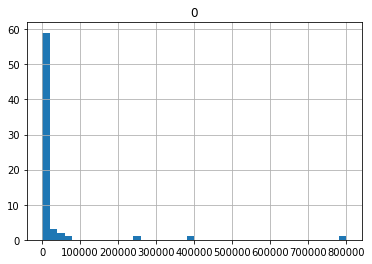

In [31]:
cluster_stat(tds_big_dict,tds_df)

In [32]:
write2pkl(tds_df,tds_big_dict,677,"tds_1")
write2pkl(tds_df,tds_big_dict,664,"tds_2")
write2pkl(tds_df,tds_big_dict,4502,"tds_3")


Unique Country#: 25 Unique IP#: 80 Session#: 800831
Unique Country#: 89 Unique IP#: 972 Session#: 397886
Unique Country#: 28 Unique IP#: 85 Session#: 250370


In [316]:
tds_df[tds_df.ip_src == '116.98.142.146']

,session_time,session_time_list,session_duration,session_tt_packet,session_i_tt_packet,session_o_tt_packet,session_tt_frame_length,session_i_tt_frame_length,session_o_tt_frame_length,udp_tt_length,udp_i_tt_length,udp_o_tt_length,udp_i_avg_length,udp_o_avg_length,icmp_i_avg_length,icmp_o_avg_length,icmp_tt_original_datagram_length,icmp_i_tt_datagram_length,icmp_o_tt_datagram_length,icmp_i_avg_datagram_length,icmp_o_avg_datagram_length,tcp_tt_payload_length,tcp_i_tt_payload_length,tcp_o_tt_payload_length,tcp_i_avg_payload_length,tcp_o_avg_payload_length,ip_src,ip_dst,tcp_srcport,tcp_dstport,udp_srcport,udp_dstport,country,city,subdivisions,domain,frame_i_common_protocols,frame_o_common_protocols,frame_i_max_protocols,frame_o_max_protocols,tcp_i_payload_list,tcp_o_payload_list
8880,1.578652e+09,"[1578652258.789153, 1578652258.7894, 157865225...",1.208934,8,5,3,732,478.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,196.0,74.0,39.200000,24.666667,116.98.142.146,210.242.145.125,39341.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M5YxTvuw3zLw7Ve9VgfY1QWxQtTVGgZA+Oi56imXJ...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8893,1.578651e+09,"[1578650551.93434, 1578650551.934552, 15786505...",0.576697,8,5,3,730,476.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.145.65,33691.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoyDV33uuEftajiA+Oi56iEvXJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8950,1.578648e+09,"[1578647726.148316, 1578647726.148473, 1578647...",1.452684,10,6,4,924,542.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.0,194.0,148.0,32.333333,37.000000,116.98.142.146,210.242.145.65,47653.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw3zLoy7xVZABVZeLpCZpCZp9sAPt3ppA+...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8956,1.578651e+09,"[1578651049.900827, 1578651049.901286, 1578651...",93.001999,14,8,6,1280,840.0,440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.0,384.0,74.0,48.000000,12.333333,116.98.142.146,210.242.145.65,48028.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpTuKZpVZAaE3YpyoyVfpA+Oi56iE...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
8959,1.578648e+09,"[1578647865.141733, 1578647865.142038, 1578647...",0.592815,10,6,4,922,540.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340.0,192.0,148.0,32.000000,37.000000,116.98.142.146,210.242.145.65,48704.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:M4YxTvuw36GmRpJinvhtIJ1VNVQA+Oi56iEvXJ:M9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50218448,1.578653e+09,"[1578652838.658343, 1578652838.658545, 1578652...",0.670841,8,5,3,724,476.0,248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,194.0,74.0,38.800000,24.666667,116.98.142.146,210.242.149.123,49321.0,1433.0,NaN,NaN,Vietnam,Quảng Ngãi,Quảng Ngãi Province,viettel.vn,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp,eth:ethertype:ip:tcp:tds:gss-api,eth:ethertype:ip:tcp:tds,[[12:MdjYxTvuw36I2OTApieK5xCVtpA+Oi5ac8VlJ:MC9...,[[6:Sf/U/93+uST5O3S3QWi2VfaSCI9uMQy6sd:s/U/B+u...
50218459,1.578653e+09,"[1578652571.62375, 1578652571.623942, 15786525...",149.046448,22,11,11,19

In [317]:
key_ = find_cluster(tds_big_dict,50218448)
write2pkl(tds_df,tds_big_dict,key_,4)

Unique Country#: 35 Unique IP#: 177 Session#: 1335894


#### smtp

In [33]:
smtp_df, smtp_df_payload = prepare_df(df2,'smtp')
smtp_big_dict = similarity_compare(smtp_df,smtp_df_payload)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

238

原本總共sessions#: 13945
共有#sessions可分群: 13897 共有#lonerSessions: 48
可分為#群: 29
前三大的cluster key與對應之群集大小
 880       12007
462476      358
131327      315
134687      309
158784      152
Name: 0, dtype: int64
                  0
count     29.000000
mean     479.206897
std     2219.281679
min        2.000000
25%       11.000000
50%       23.000000
75%       71.000000
max    12007.000000


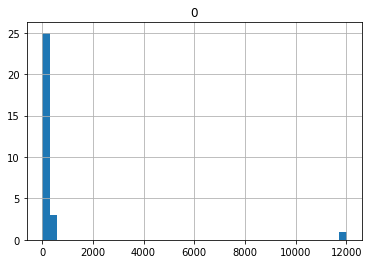

In [34]:
cluster_stat(smtp_big_dict,smtp_df)

In [35]:
write2pkl(smtp_df,smtp_big_dict,880,"smtp_1")
write2pkl(smtp_df,smtp_big_dict,462476,"smtp_2")
write2pkl(smtp_df,smtp_big_dict,131327,"smtp_3")


Unique Country#: 8 Unique IP#: 29 Session#: 12007
Unique Country#: 1 Unique IP#: 1 Session#: 358
Unique Country#: 10 Unique IP#: 31 Session#: 315


#### FTP

In [36]:
ftp_df, ftp_df_payload = prepare_df(df2,'ftp')
ftp_big_dict = similarity_compare(ftp_df,ftp_df_payload)
gc.collect()

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

0

原本總共sessions#: 6322
共有#sessions可分群: 6317 共有#lonerSessions: 5
可分為#群: 36
前三大的cluster key與對應之群集大小
 1091      1902
1190      1248
1527      1035
63379      817
134623     242
Name: 0, dtype: int64
                 0
count    36.000000
mean    175.472222
std     413.800952
min       2.000000
25%       6.000000
50%      19.000000
75%      52.750000
max    1902.000000


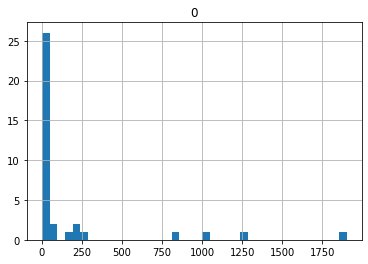

In [37]:
cluster_stat(ftp_big_dict,ftp_df)

In [38]:
write2pkl(ftp_df,ftp_big_dict,1091,"ftp_1")
write2pkl(ftp_df,ftp_big_dict,1190,"ftp_2")
write2pkl(ftp_df,ftp_big_dict,1527,"ftp_3")


Unique Country#: 8 Unique IP#: 14 Session#: 1902
Unique Country#: 9 Unique IP#: 26 Session#: 1248
Unique Country#: 8 Unique IP#: 128 Session#: 1035


### sip

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

原本總共sessions#: 425
共有#sessions可分群: 424 共有#lonerSessions: 1
可分為#群: 3
前三大的cluster key與對應之群集大小
 18841     301
131584     69
334787     54
Name: 0, dtype: int64
                0
count    3.000000
mean   141.333333
std    138.478639
min     54.000000
25%     61.500000
50%     69.000000
75%    185.000000
max    301.000000


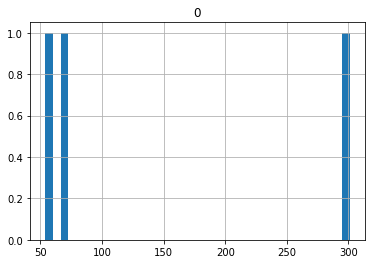

In [39]:
sip_df, sip_df_payload = prepare_df(df2,'sip')
sip_big_dict = similarity_compare(sip_df,sip_df_payload)
cluster_stat(sip_big_dict,sip_df)

In [40]:
write2pkl(sip_df,sip_big_dict,18841,"sip_1")
write2pkl(sip_df,sip_big_dict,131584,"sip_2")
write2pkl(sip_df,sip_big_dict,334787,"sip_3")


Unique Country#: 1 Unique IP#: 48 Session#: 301
Unique Country#: 1 Unique IP#: 1 Session#: 69
Unique Country#: 2 Unique IP#: 4 Session#: 54


#### Mysql

/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/.local/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

原本總共sessions#: 748
共有#sessions可分群: 748 共有#lonerSessions: 0
可分為#群: 3
前五大的cluster key與對應之群集大小
 6156    486
1394    236
9804     26
Name: 0, dtype: int64
                0
count    3.000000
mean   249.333333
std    230.289673
min     26.000000
25%    131.000000
50%    236.000000
75%    361.000000
max    486.000000


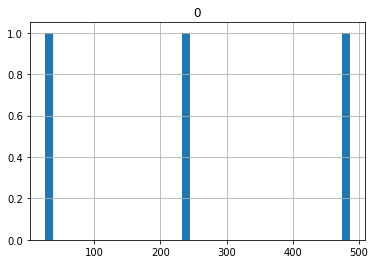

In [116]:
mysql_df, mysql_df_payload = prepare_df(df2,'mysql')
mysql_big_dict,mysql_loners,mysql_scores = similarity_compare(mysql_df,mysql_df_payload,thr=20)
cluster_stat(mysql_big_dict,mysql_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbabe0af10>]],
      dtype=object)

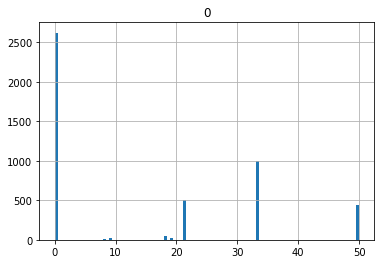

In [115]:
pd.DataFrame(mysql_scores).hist(bins=100)

In [117]:
write2pkl(mysql_df,mysql_big_dict,6156,"mysql_1")
write2pkl(mysql_df,mysql_big_dict,1394,"mysql_2")
write2pkl(mysql_df,mysql_big_dict,9804,"mysql_3")


Unique Country#: 5 Unique IP#: 22 Session#: 486
Unique Country#: 4 Unique IP#: 6 Session#: 236
Unique Country#: 1 Unique IP#: 1 Session#: 26


In [44]:
pickle.dump(obj=(http_big_dict,smb_big_dict,telnet_big_dict,tds_big_dict,smtp_big_dict,ftp_big_dict,
                 sip_big_dict,mysql_big_dict),file=open(pickle_dir+"allProtocol_case_dict.pkl",'wb'))

# Deprecated
* old original function

In [69]:
def build_matrix(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    big_dict = {}
    all_scores = []
    for i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
        packets_num = len(packets_payload)
        q1 = int(packets_num/4)
        q2 = int(packets_num/2)
        q3 = int(packets_num*0.75)
        
        tryq1 = packets_payload[q1]
        tryq1_split = tryq1.split(':')
        q1len_segment = tryq1_split[0]
        q1len_payload = ":".join(tryq1_split[1:])        
        if q1 == q2 == q3:
            flag=False
        else:
            tryq2 = packets_payload[q2]
            tryq2_split = tryq2.split(':')
            q2len_segment = tryq2_split[0]
            q2len_payload = ":".join(tryq2_split[1:])
            
            tryq3 = packets_payload[q3]
            tryq3_split = tryq3.split(':')
            q3len_segment = tryq3_split[0]
            q3len_payload = ":".join(tryq3_split[1:])            
            flag = True

        final_li = []
        for j in range(sessions_num-i-1): #往下比
            idx_compare = j+i+1
            session_payload_compare = sessions_payload[idx_compare]
            session_score = []
            for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
                test_segment = packet_payload_compare.split(':')[0]
                if test_segment == q1len_segment:
                    scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
                else:
                    scoreq1 = 0
                if flag:
                    if test_segment == q2len_segment:
                        scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
                    else:
                        scoreq2 = 0
                    if test_segment == q3len_segment:
                        scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
                    else:
                        scoreq3 = 0
                    if scoreq1 == scoreq2 == scoreq3 <1:
                        min_packet = packets_payload[0]
                        max_packet = packets_payload[-1]
                        scoreMin = 0
                        scoreMax = 0
                        if min_packet.split(':')[0] == test_segment:
                            scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                        if max_packet.split(':')[0] == test_segment:
                            scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                        session_score.append(max(scoreMin,scoreMax))
                        continue
                session_score.append(max(scoreq1,scoreq2,scoreq3))
            final_score = max(session_score)
            if final_score>0:
                final_li.append((idxes[idx_compare],final_score))
                all_scores.append(final_score) #統計用
        big_dict[idx] = final_li
    return big_dict,all_scores
#                 test_split = packet_payload_compare.split(':')
#                 test_segment = test_split[0]
#                 if 

In [93]:
%%time
def build_matrix_mu(sessions_payload,idxes):
    '''
    sessions_payload: list of lists (hashes)
    idxes: list (corresponding Index)
    
    Return: dictionry=> key=idx,value=list of tuples (idx_compare,final_session_score)
    '''
    sessions_num = len(sessions_payload)
    assert  sessions_num == len(idxes)
    inputs = [(i,x,y) for i,(x,y) in enumerate(zip(sessions_payload,idxes))]
    
    
#     all_scores = []
def func(param):#i,(packets_payload,idx) in tqdm(enumerate(zip(sessions_payload,idxes))):
    i,packets_payload,idx = param
    big_dict = {}
    packets_num = len(packets_payload)
    q1 = int(packets_num/4)
    q2 = int(packets_num/2)
    q3 = int(packets_num*0.75)

    tryq1 = packets_payload[q1]
    tryq1_split = tryq1.split(':')
    q1len_segment = tryq1_split[0]
    q1len_payload = ":".join(tryq1_split[1:])        
    if q1 == q2 == q3:
        flag=False
    else:
        tryq2 = packets_payload[q2]
        tryq2_split = tryq2.split(':')
        q2len_segment = tryq2_split[0]
        q2len_payload = ":".join(tryq2_split[1:])

        tryq3 = packets_payload[q3]
        tryq3_split = tryq3.split(':')
        q3len_segment = tryq3_split[0]
        q3len_payload = ":".join(tryq3_split[1:])            
        flag = True

    final_li = []
    for j in range(sessions_num-i-1): #往下比
        idx_compare = j+i+1
        session_payload_compare = sessions_payload[idx_compare]
        session_score = []
        for packet_payload_compare in session_payload_compare: #packet_payload_compare == '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m'                
            test_segment = packet_payload_compare.split(':')[0]
            scoreq1 = scoreq2 = scoreq3 = 0
            if test_segment == q1len_segment:
                scoreq1 = ssdeep.compare(tryq1,packet_payload_compare)
#             else:
#                 scoreq1 = 0
            if flag:
#                 scoreq2 = 0
                if test_segment == q2len_segment:
                    scoreq2 = ssdeep.compare(tryq2,packet_payload_compare)
#                 else:
#                     scoreq2 = 0
#                 scoreq3 = 0
                if test_segment == q3len_segment:
                    scoreq3 = ssdeep.compare(tryq3,packet_payload_compare)
#                 else:
#                     scoreq3 = 0
                if scoreq1 == scoreq2 == scoreq3 <1:
                    min_packet = packets_payload[0]
                    max_packet = packets_payload[-1]
                    scoreMin = scoreMax = 0
#                     scoreMax = 0
                    if min_packet.split(':')[0] == test_segment:
                        scoreMin = ssdeep.compare(min_packet,packet_payload_compare) #第一個時間得比較
                    if max_packet.split(':')[0] == test_segment:
                        scoreMax = ssdeep.compare(max_packet,packet_payload_compare) #最後一個時間得比較
                    session_score.append(max(scoreMin,scoreMax))
                    continue
            session_score.append(max(scoreq1,scoreq2,scoreq3))
        final_score = max(session_score)
        if final_score>0:
            final_li.append((idxes[idx_compare],final_score))
#             all_scores.append(final_score) #統計用
    big_dict[idx] = final_li

#         pool = Pool()
inputs = [(i,x,y) for i,(x,y) in enumerate(zip(session_payload,df2_http.index))]
sessions_num = len(session_payload)
sessions_payload=session_payload
idxes = df2_http.index
pool = Pool()
start = time.time()
out_li = pool.map(func,inputs)
end = time.time()
# with mp.Manager() as manager:
#     big_dict = manager.dict()
#     with manager.Pool() as pool:
#         pool.map(func, inputs) #(sessions_num,i,sessions_payload,q1len_segment,tryq1,q2len_segment,tryq2,q3len_segment,
            #tryq3,packets_payload)
#     return big_dict#,all_scores

#5h 33min 29s

CPU times: user 17.3 s, sys: 19 s, total: 36.4 s
Wall time: 5h 33min 29s


Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-47:
Process ForkPoolWorker-42:
Process ForkPoolWorker-39:
Process ForkPoolWorker-44:
Process ForkPoolWorker-40:
Process ForkPoolWorker-41:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [109]:
for i in range(len(out_li)):
    if out_li[i] != None:
        print(out_li[i])


In [ ]:
inputs = []
for i,(packets_payload,idx) in tqdm(enumerate(zip(session_payload,df2_http.index))):
    inputs.append((i,packets_payload,idx))
    for 

In [85]:
big_dict

<DictProxy object, typeid 'dict' at 0x7f4c85590d50>

In [78]:
one,two = build_matrix_mu(session_payload,df2_http.index) #1.05~1.6

AttributeError: Can't pickle local object 'build_matrix_mu.<locals>.func'

In [62]:
max(0,0)

0

In [59]:
session_payload[0]

['6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m',
 '6:rHKAqEDxghMRo5auSGy6A7WfXl3Nupfh/aEjmjmn:rHXq6xmMRe9SNYV3NkZr8m']

In [56]:
a = '6:rHKA2y6A7GyGTSjkRB9LyhvXfLTYCSUBKAQNWjyGTbzNupfh/aEjmjmn:rHX9Gy9kRB9GfLTYR+ygNkZr8m'.split(":")
":".join(a[1:])

'rHKA2y6A7GyGTSjkRB9LyhvXfLTYCSUBKAQNWjyGTbzNupfh/aEjmjmn:rHX9Gy9kRB9GfLTYR+ygNkZr8m'

In [58]:
for i in range(1):
    print(i)

0


In [46]:
session_payload[7]

['6:rHKA2y6A7GyGTSjkRB9LyhvXfLTYCSUBKAQNWjyGTbzNupfh/aEjmjmn:rHX9Gy9kRB9GfLTYR+ygNkZr8m']

In [36]:
payload_li[-2][1]#[:,0]

array(['3:Sfrfun:Sfrmn', '1578607824.826388000'], dtype=object)

In [29]:
df2_http.iloc[-2,-2]#[0][0] # select in bound payload, select first packet , select hash

array([array(['3:cRm5tD+U/2:rHKA2', '1578607824.482844000'], dtype=object),
       array(['3:Sfrfun:Sfrmn', '1578607824.826388000'], dtype=object)],
      dtype=object)

In [52]:
ssdeep.compare(session_payload[7][0],session_payload[6][0])

0